# SwinUnet With Flair 1


## Content

1. [Installation](#installation)
1. [Dataset](#dataset)
1. [Quick Start](#quickstart)

<a id='installation'></a>
## 1. Installation

#### Dependencies




In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import needed packages
import sys
from tqdm import tqdm
import torch.nn as nn
import torch
import os
from torch.utils.data import DataLoader
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('../..')
from RESNET_UNet.py_module.data_display import (get_data_paths,                                   
                                   display_samples)
from tools.utils import Dataset_Flair1

from SwinUnet.vision_transformer import SwinUnet
from tools.utils import PixelwiseMetrics, print_metrics_Flair1_acc, generate_metrics_acc, generate_miou, print_metrics_Flair1, predict_and_save_flair


In [8]:
path_to_module_1 = '/content/drive/My Drive/Projet Computer Vision/LandCover_map_Transformers_SSL/src'
sys.path.append(path_to_module_1)

In [9]:
!pip install einops
!pip install rasterio
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.0 MB/s eta 0:00:00


<a id='dataset'></a>
## 2. Dataset


#### Download

 In this notebook, we will use a part of Flair1 dataset to train downstream tasks.  

#### Configure

For example, in the `data_config` dictionary (cell below), you can specify paths to the data directory with `train_dir` and `val_dir` or the image input size with `image_px_size`.

In [97]:
path_toy_dataset_folder = '/content/drive/My Drive/flair1_fullset_13classes/train'
sys.path.append(path_toy_dataset_folder)

images = sorted(list(get_data_paths(Path(path_toy_dataset_folder), 'image*.tif')), key=lambda x: int(x.split('_')[-1][:-4]))
masks  = sorted(list(get_data_paths(Path(path_toy_dataset_folder), 'mask*.tif')), key=lambda x: int(x.split('_')[-1][:-4]))

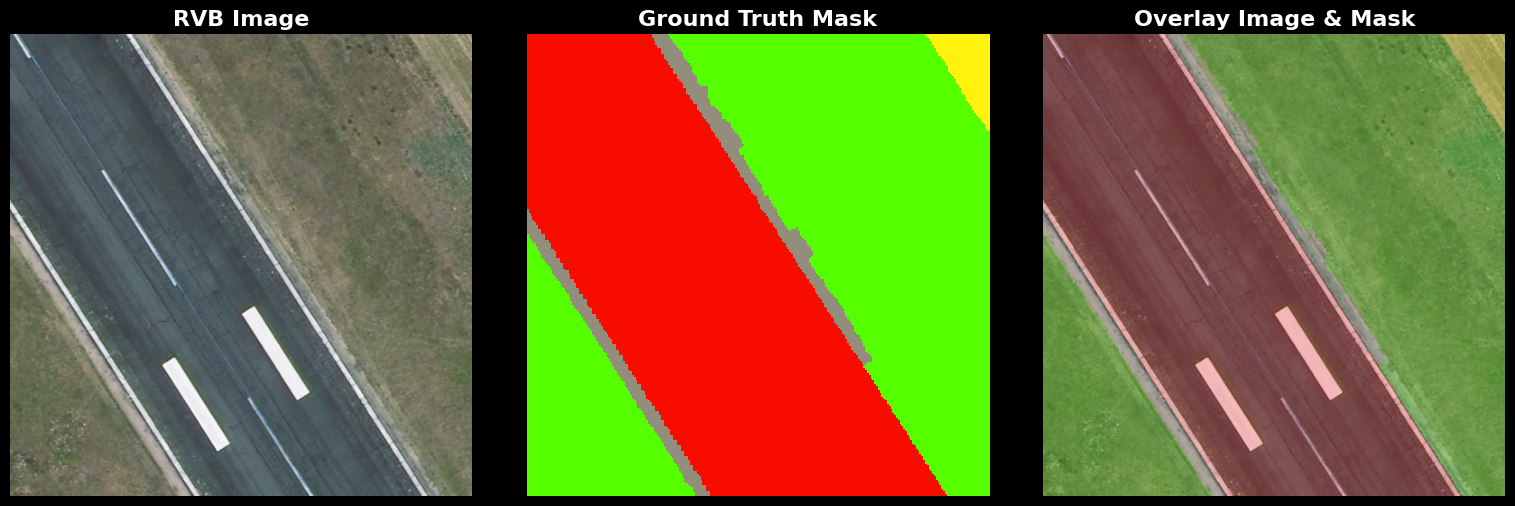

In [98]:
display_samples(images, masks, nb_samples= 1)

#### Prepare

We create the `train_dataset` and `val_dataset` by using the `DFCDataset`, a custom class of `torch.utils.data.Dataset`

In [12]:
# Create dataset objects for each set
train_dataset = Dataset_Flair1(root_dir='/content/drive/My Drive/flair1_fullset_13classes/train')
test_dataset = Dataset_Flair1(root_dir='/content/drive/My Drive/flair1_fullset_13classes/test')
val_dataset = Dataset_Flair1(root_dir='/content/drive/My Drive/flair1_fullset_13classes/val')


We define a correspondance of label and names:

In [13]:
dict_classes = {
1   : 'building',
2   : 'pervious surface',
3   : 'impervious surface',
4   : 'bare soil',
5   : 'water',
6   : 'coniferous',
7   : 'deciduous',
8   : 'brushwood',
9   : 'vineyard',
10  : 'herbaceous vegetation',
11  : 'agricultural land',
12  : 'plowed land',
13  : 'other'}

Our data is now ready to be used by the model. In the next section we load and configure the model.

<a id='quickstart'></a>
## 3. Quick Start

#### Configure

You can specify in the some hyperparameters in `train_config`  and `model_config` (cell below).

In [14]:
# Training configurations
model_config = {'img_size': 224,
                 'patch_size': 4,
                 'in_chans':5,
                 'num_classes':13,
                 'embed_dim': 96,
                 'depths':[2, 2, 2, 2],
                 'depths_decoder': [1, 2, 2, 2],
                 'num_heads' :[3, 6, 12, 24],
                 'window_size':7,
                  'mlp_ratio' :4.,
                    'qkv_bias' : True,
                    'qk_scale': None,
                 'drop_rate' :0.,
                'attn_drop_rate':0.,
                'drop_path_rate':0.1,
                 'norm_layer': nn.LayerNorm,
                 'ape': False,
                'patch_norm': True,
                 'use_checkpoint' :False,
                 'final_upsample' :"expand_first"
                }

train_config = {
    'input_channels': 5,
    'classifier_lr': 3e-6,
    'learning_rate': 0.001,
    'adam_betas': (0.9, 0.999),
    'weight_decay': 0.001,
    'dataloader_workers': 6,
    'batch_size': 4,
    'epochs': 45
}

#### Prepare model

In [15]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu:0")

In [16]:
model = SwinUnet(config=model_config, num_classes=model_config['num_classes'])

model = model.to(device)

SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:13


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---final upsample expand_first---


Define and initialise the loss for training.

In [13]:
criterion = torch.nn.CrossEntropyLoss(ignore_index=255, reduction="mean").to(device)

Initialise the selected optimizer. In this work we chose Adam optimizer. You can initialise any optimizer you want.

In [14]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=train_config['learning_rate'],
    betas=train_config['adam_betas'],
    weight_decay=train_config['weight_decay'],
)

We load the data (training and validation) using pytorch's dataloader

In [20]:
# Define the path for saving the model
model_save_path = '/content/drive/My Drive/Checkpoints/SwinUnet_Flair1_best_model.pth'

In [64]:
# Create data loaders
train_loader = DataLoader(train_dataset,
                          batch_size=model_config['patch_size'],
                          shuffle=True)

test_loader = DataLoader(test_dataset,
                         batch_size=model_config['patch_size'],
                         shuffle=False)

val_loader = DataLoader(val_dataset,
                        batch_size=model_config['patch_size'],
                        shuffle=False)

Everything is set and we are now ready to train our model:

In [18]:
# Ensure necessary classes like ConfMatrix, PixelwiseMetrics are imported
# from utils import ConfMatrix, PixelwiseMetrics, generate_miou

num_classes = model_config['num_classes']

class EarlyStopping:
    """ Class for early stopping """
    def __init__(self, patience=6, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

def train_segmentation_model(epochs, train_loader, val_loader, model, optimizer, criterion, num_classes):
    early_stopper = EarlyStopping(patience=6)
    best_val_loss = float('inf')
    best_model_wts = None

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses, train_metrics = [], PixelwiseMetrics(num_classes)

        for sample in tqdm(train_loader):
            x = sample['img'].to(device)
            truth = sample['msk'].to(device)

            optimizer.zero_grad()
            y_hat = model(x)
            loss = criterion(y_hat, truth)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            pred = torch.argmax(y_hat, dim=1)
            train_metrics.add_batch(truth, pred)

        # Calculate training statistics
        train_loss = np.mean(train_losses)
        train_acc = train_metrics.get_average_accuracy()

        # Validation Phase
        if epoch % 2 == 0:
            model.eval()
            val_losses, val_metrics = [], PixelwiseMetrics(num_classes)
            with torch.no_grad():
                for sample in tqdm(val_loader):
                    x = sample['img'].to(device)
                    y = sample['msk'].to(device)
                    y = torch.squeeze(y, 1)  # Remove if masks are already in (N, H, W) format

                    y_hat = model(x)
                    loss = criterion(y_hat, y)

                    val_losses.append(loss.item())
                    pred = torch.argmax(y_hat, dim=1)
                    val_metrics.add_batch(y, pred)

            # Calculate validation statistics
            val_loss = np.mean(val_losses)
            val_acc = val_metrics.get_average_accuracy()

            # Print statistics
            print(f'Epoch {epoch}: Train Loss: {train_loss}, Train Acc: {train_acc}, Val Loss: {val_loss}, Val Acc: {val_acc}')

            # Save the best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_wts = model.state_dict()

            # Early stopping
            early_stopper(val_loss)
            if early_stopper.early_stop:
                print("Early stopping triggered")
                break

    # Save best model weights after training loop
    if best_model_wts:
       os.makedirs(os.path.dirname(model_save_path), exist_ok=True)  # Ensure the directory exists
       torch.save(best_model_wts, model_save_path)
       print(f"Best model saved to {model_save_path}.")


    print("Training completed.")



In [18]:
train_segmentation_model(train_config['epochs'], train_loader, val_loader, model, optimizer, criterion, num_classes)

100%|██████████| 104/104 [00:48<00:00,  2.15it/s]


Epoch 0: Train Loss: 1.599667657023439, Train Acc: 0.23741511688655803, Val Loss: 1.3283802139071317, Val Acc: 0.2811387012298051


100%|██████████| 104/104 [00:27<00:00,  3.83it/s]


Epoch 2: Train Loss: 1.2705045743630483, Train Acc: 0.3436289553798295, Val Loss: 1.2683225279817214, Val Acc: 0.3314206005846746


100%|██████████| 104/104 [00:25<00:00,  4.15it/s]


Epoch 4: Train Loss: 1.1810952548940594, Train Acc: 0.3924275980092836, Val Loss: 1.3044034322867026, Val Acc: 0.41653252129087226


100%|██████████| 104/104 [00:25<00:00,  4.16it/s]


Epoch 6: Train Loss: 1.0905681173675335, Train Acc: 0.4266112711924452, Val Loss: 1.058656826042212, Val Acc: 0.4246414541783809


100%|██████████| 104/104 [00:24<00:00,  4.23it/s]


Epoch 8: Train Loss: 1.068303135725168, Train Acc: 0.4355569302613051, Val Loss: 1.0441520305780263, Val Acc: 0.4318058594200633


100%|██████████| 104/104 [00:25<00:00,  4.09it/s]


Epoch 10: Train Loss: 1.0249157756423721, Train Acc: 0.4508296134699093, Val Loss: 0.9914822956690421, Val Acc: 0.45662425320500927


100%|██████████| 104/104 [00:25<00:00,  4.08it/s]


Epoch 12: Train Loss: 1.029458899838993, Train Acc: 0.4530158036962873, Val Loss: 0.9915188622589295, Val Acc: 0.49682021763708595


100%|██████████| 104/104 [00:25<00:00,  4.15it/s]


Epoch 14: Train Loss: 0.9842137078253123, Train Acc: 0.4705247686017456, Val Loss: 1.0472586911458235, Val Acc: 0.48664982969595366


100%|██████████| 104/104 [00:25<00:00,  4.03it/s]


Epoch 16: Train Loss: 0.9729440402812682, Train Acc: 0.48663290225922445, Val Loss: 0.95377531217841, Val Acc: 0.47839732041217187


100%|██████████| 104/104 [00:24<00:00,  4.18it/s]


Epoch 18: Train Loss: 0.9718698288242404, Train Acc: 0.48072549534319015, Val Loss: 0.9283541016853772, Val Acc: 0.4485033220803049


100%|██████████| 104/104 [00:25<00:00,  4.08it/s]


Epoch 20: Train Loss: 0.9562724302164637, Train Acc: 0.49282880487872843, Val Loss: 0.9667031094431877, Val Acc: 0.5439394419253087


100%|██████████| 104/104 [00:25<00:00,  4.05it/s]


Epoch 22: Train Loss: 0.9426534702428259, Train Acc: 0.5017861405571611, Val Loss: 0.9575552728313667, Val Acc: 0.4891761634975992


100%|██████████| 104/104 [00:25<00:00,  4.13it/s]


Epoch 24: Train Loss: 0.9337703054054425, Train Acc: 0.5037580729962395, Val Loss: 0.8987769911495539, Val Acc: 0.5420530101115484


100%|██████████| 104/104 [00:25<00:00,  4.12it/s]


Epoch 26: Train Loss: 0.9412936462232699, Train Acc: 0.5001821954669746, Val Loss: 0.9530020889181358, Val Acc: 0.45672175355991784


100%|██████████| 104/104 [00:26<00:00,  3.98it/s]


Epoch 28: Train Loss: 0.9099220037460327, Train Acc: 0.5176861641145901, Val Loss: 0.8965634153439448, Val Acc: 0.5150056820181785


100%|██████████| 104/104 [00:24<00:00,  4.27it/s]


Epoch 30: Train Loss: 0.8963286815067897, Train Acc: 0.533921932641518, Val Loss: 0.8543082489990271, Val Acc: 0.5617380650122766


100%|██████████| 104/104 [00:24<00:00,  4.24it/s]


Epoch 32: Train Loss: 0.8933594038423437, Train Acc: 0.5305679626397387, Val Loss: 0.961780168975775, Val Acc: 0.5053848857182489


100%|██████████| 104/104 [00:25<00:00,  4.14it/s]


Epoch 34: Train Loss: 0.90257006804817, Train Acc: 0.529243954046881, Val Loss: 0.8912969942276294, Val Acc: 0.5346405032597403


100%|██████████| 104/104 [00:24<00:00,  4.28it/s]


Epoch 36: Train Loss: 0.881080630593575, Train Acc: 0.5358114954239758, Val Loss: 0.8763160754281741, Val Acc: 0.5677162446540949


100%|██████████| 104/104 [00:24<00:00,  4.19it/s]


Epoch 38: Train Loss: 0.8763340179665158, Train Acc: 0.5424992689326137, Val Loss: 0.8967896963541324, Val Acc: 0.5948488898407077


100%|██████████| 104/104 [00:24<00:00,  4.16it/s]


Epoch 40: Train Loss: 0.8638327850673634, Train Acc: 0.5472136663479286, Val Loss: 0.8356219587417749, Val Acc: 0.5393794280529355


100%|██████████| 104/104 [00:25<00:00,  4.16it/s]


Epoch 42: Train Loss: 0.8706934089557483, Train Acc: 0.5502001999787047, Val Loss: 0.8640753681269976, Val Acc: 0.589912149830011


100%|██████████| 104/104 [00:24<00:00,  4.22it/s]


Epoch 44: Train Loss: 0.8562589906012783, Train Acc: 0.5416250969425922, Val Loss: 0.8383652158081532, Val Acc: 0.5205174644878633
Best model saved to /content/drive/My Drive/Checkpoints/SwinUnet_Flair1_best_model.pth.
Training completed.


You can evaluate the model on one example by creating a model's instance, loading checkpoint's weights of the classifier saved during training, running it, and displaying the results:

SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:13
---final upsample expand_first---


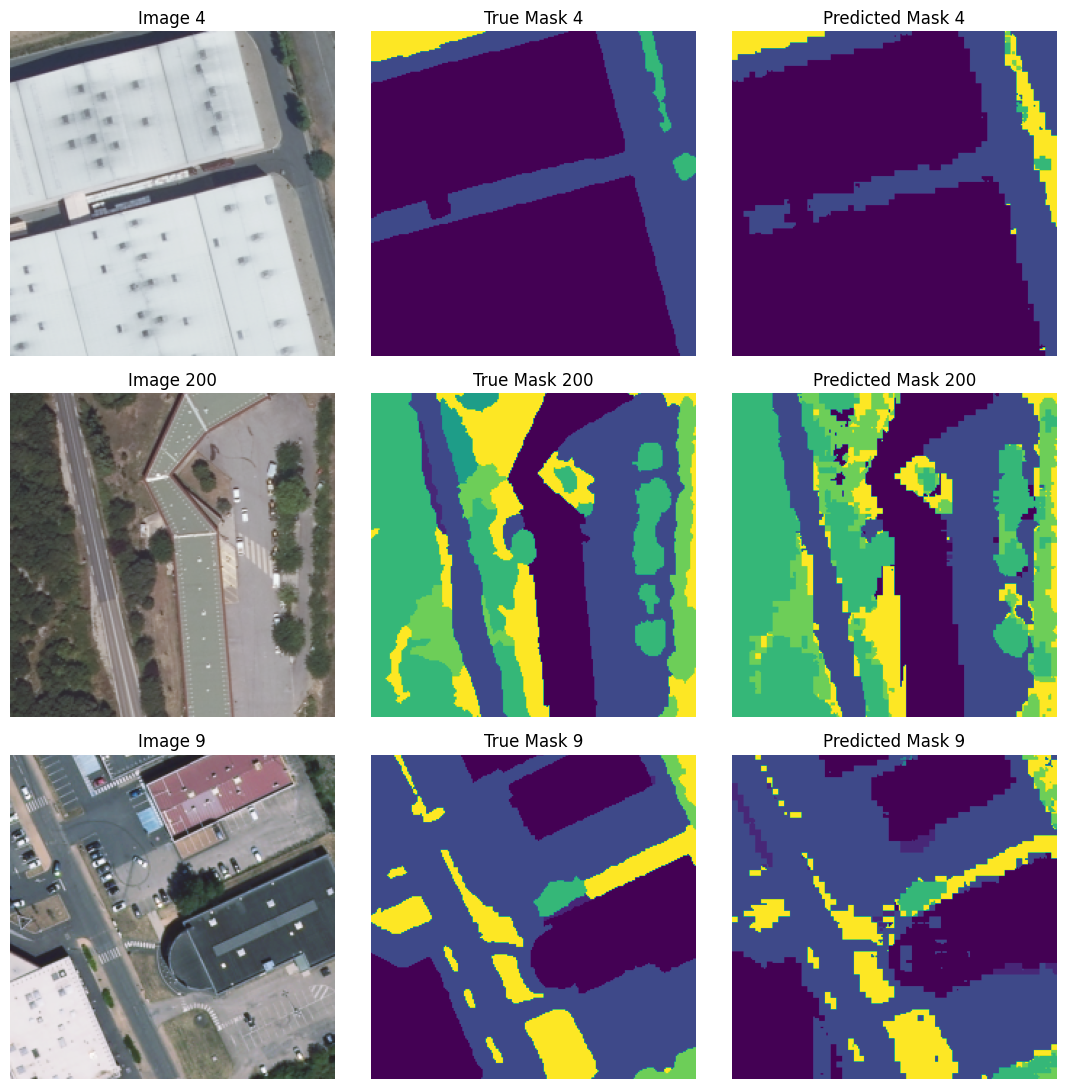

In [111]:
# Create a new instance of the model
model = SwinUnet(model_config, num_classes=13)
model = model.to(device)

# Load checkpoint weights
model.load_state_dict(torch.load(model_save_path))


# Set the model to evaluation mode
model.eval()


indices = [4, 200, 9]

# Create a subplot grid
fig, axes = plt.subplots(3, 3, figsize=(11, 11))

for i, idx in enumerate(indices):
    # Prepare the input
    img = torch.unsqueeze(test_dataset[idx]['img'], 0).to(device)
    true_mask = test_dataset[idx]['msk'].squeeze(0).cpu().numpy()

    # Get the model output
    output = model(img)
    output = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
    # Display the image
    rgb_image = img.squeeze().cpu().permute(1, 2, 0)[..., :3]
    axes[i, 0].imshow(rgb_image)  # Assuming img is a tensor of shape [C, H, W]
    axes[i, 0].set_title(f'Image {idx}')
    axes[i, 0].axis('off')

    # Display the true mask
    axes[i, 1].imshow(true_mask)
    axes[i, 1].set_title(f'True Mask {idx}')
    axes[i, 1].axis('off')

    # Display the predicted mask
    axes[i, 2].imshow(output)
    axes[i, 2].set_title(f'Predicted Mask {idx}')
    axes[i, 2].axis('off')

# Show the plots
plt.tight_layout()
plt.show()



In [77]:
pred_msk = '/content/drive/My Drive/Projet Computer Vision/pred_SwinT_Flair'

predict_and_save_flair(test_dataset, pred_msk, model, device='cuda')

Predictions successfully saved.


In [81]:
mIou, ious = generate_miou(test_dataset, pred_msk, S = 'msk')
print_metrics_Flair1(mIou, ious)



----------------------------------------
         Model mIoU :  0.4583
----------------------------------------
Class                     iou            
----------------------------------------
building                  0.6120292988769761
pervious surface          0.13920159535834403
impervious surface        0.6552981523477774
bare soil                 0.00628468780347897
water                     0.8222413672511205
coniferous                0.319677112645337
deciduous                 0.6890876673450868
brushwood                 0.3411848252870187
vineyard                  0.8372211330560643
herbaceous vegetation     0.5609587874465625
agricultural land         0.2827892687960227
plowed land               0.2338642568789673





In [96]:
metrics = generate_metrics_acc(test_dataset, pred_msk, S= "msk")
classwise_accuracy = metrics["classwise_accuracy"]
overall_accuracy = metrics["overall_accuracy"]
print_metrics_Flair1_acc(overall_accuracy, classwise_accuracy)



----------------------------------------
         Model accuracy :  0.7051
----------------------------------------
Class                     accuracy       
----------------------------------------
building                  0.8332475998879524
pervious surface          0.16012370129649595
impervious surface        0.8198447508032418
bare soil                 0.0063516118041323615
water                     0.8579310680365175
coniferous                0.34029702736523976
deciduous                 0.8797766051986249
brushwood                 0.5026232997536192
vineyard                  0.8896444454007834
herbaceous vegetation     0.8111105978448301
agricultural land         0.34671684070934145
plowed land               0.25934145550916127
other                     0.0            



